Found 2527 files belonging to 6 classes.
Using 2022 files for training.
Found 2527 files belonging to 6 classes.
Using 505 files for validation.
类别索引映射: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Class plastic: 394 samples
Class cardboard: 320 samples
Class metal: 332 samples
Class paper: 470 samples
Class glass: 398 samples
Class trash: 108 samples
Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 46s 646ms/step - accuracy: 0.3732 - loss: 1.9066 - val_accuracy: 0.7366 - val_loss: 0.9642
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 40s 624ms/step - accuracy: 0.6593 - loss: 1.1283 - val_accuracy: 0.8218 - val_loss: 0.7931
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 40s 627ms/step - accuracy: 0.7372 - loss: 0.9798 - val_accuracy: 0.8277 - val_loss: 0.7674
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 40s 624ms/step - accuracy: 0.7458 - loss: 0.9349 - val_accuracy: 0.8297 - val_loss: 0.7101
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 41s 647ms/step - accuracy: 0.7586 - loss: 0.8882 - val_accuracy: 0.8416 - va

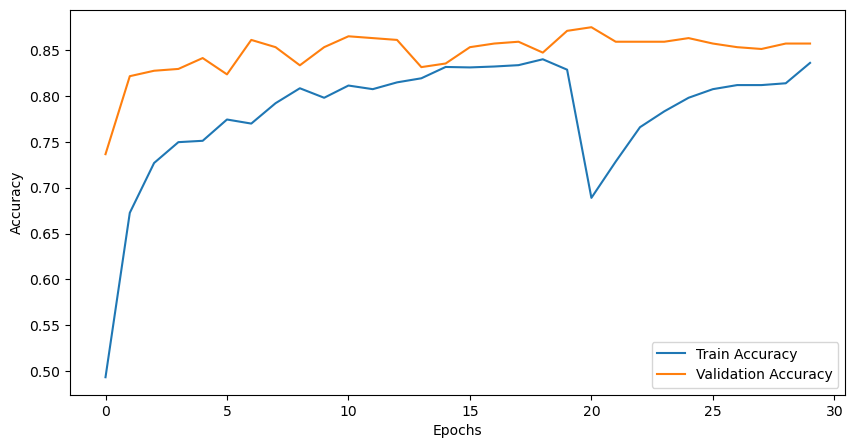

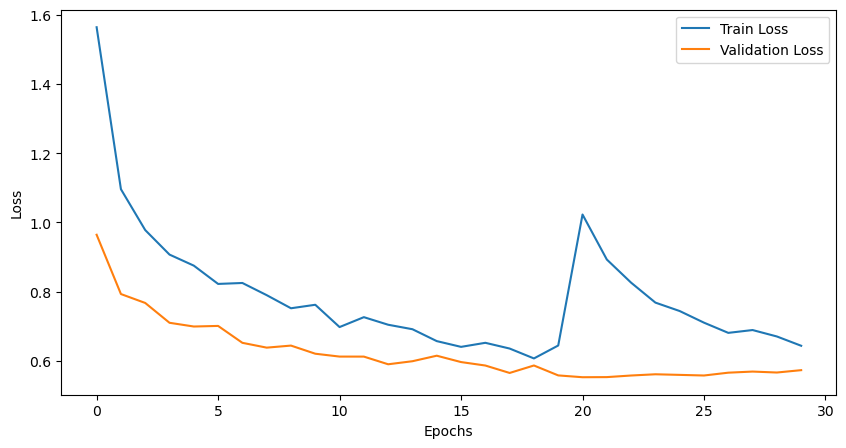

Saved!


In [1]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
from collections import Counter

# 数据加载
batch_size = 32
img_size = (224, 224)

dataset_path = "../dataset/Garbage classification/Garbage classification"

# 直接从文件夹中加载数据，并自动划分训练/验证集
train_dataset = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,  # 20% 作为验证集
    subset="training",
    seed=123,  # 设定随机种子，保证每次划分一致
    image_size=img_size,
    batch_size=batch_size
)

val_dataset = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

# 打印类别索引映射
class_names = train_dataset.class_names
print(f"类别索引映射: {class_names}")

# 统计训练数据中每个类别的样本数量
class_counts = Counter()
for images, labels in train_dataset:
    class_counts.update(labels.numpy())

# 打印类别分布
for class_idx, count in class_counts.items():
    print(f"Class {class_names[class_idx]}: {count} samples")

# 数据增强
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.3),
    layers.RandomContrast(0.3),
    layers.RandomBrightness(0.2),
])

# 加载预训练模型
base_model = keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False  # 冻结特征提取层

# 构建分类模型
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = keras.applications.mobilenet_v2.preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)  # 增加Dropout防止过拟合
x = layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.001))(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(6, activation="softmax")(x)
model = keras.Model(inputs, outputs)

# 编译模型
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# 训练模型
epochs = 20  # 增加训练轮数
history = model.fit(train_dataset, validation_data=val_dataset, epochs=epochs)

# 解冻更多层，进行微调
base_model.trainable = True
for layer in base_model.layers[:50]:  # 解冻更多层
    layer.trainable = False

# 使用更小的学习率进行微调
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.00001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

fine_tune_epochs = 10  # 增加微调轮数
history_fine = model.fit(train_dataset, validation_data=val_dataset, epochs=fine_tune_epochs)

# 绘制准确率和损失曲线
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'] + history_fine.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'] + history_fine.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'] + history_fine.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'] + history_fine.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 保存模型
model.save("classification_model.keras")
print("Saved!")

In [2]:
from sklearn.metrics import classification_report
import numpy as np

# 获取验证集的真实标签和预测标签
y_true = np.concatenate([y for x, y in val_dataset], axis=0)
y_pred = np.argmax(model.predict(val_dataset), axis=1)

# 生成分类报告
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 571ms/step
              precision    recall  f1-score   support

   cardboard       0.13      0.13      0.13        83
       glass       0.24      0.28      0.26       103
       metal       0.19      0.23      0.21        78
       paper       0.27      0.25      0.26       124
     plastic       0.19      0.15      0.17        88
       trash       0.00      0.00      0.00        29

    accuracy                           0.20       505
   macro avg       0.17      0.17      0.17       505
weighted avg       0.20      0.20      0.20       505

